# Generative Adversarial Networks with MXNet GLUON


## Import Dependencies

In [135]:
import os
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

import numpy as np

import mxnet as mx
from mxnet import ndarray as nd
from mxnet import gluon
from mxnet.gluon.data.vision import transforms
from mxnet import autograd


## Parameters and Hyperparameters

In [136]:
# This is required for dataloader num_process. Fully utilize CPUs to read and transform input data
CPU_COUNT = cpu_count()

# Training Parameters
epochs = 5
batch_size = 64
learning_rate = 0.001
# Adam Optimizer params
b1 = 0.5
b2 = 0.999

# We will use 100 dimension vector for input to Generator
latent_space_dimension = 100
# MNIST is 28*28 gray scale images 
image_size = 28
image_channels = 1
image_shape = (image_channels, image_size, image_size)

In [138]:
ctx = mx.cpu() #Use mx.gpu(0) for GPU

## Create Generator and Discriminator Network

In [139]:
# Create Generator Network
class Generator(gluon.Block):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            # Block 1
            self.model.add(gluon.nn.Dense(256, in_units=latent_space_dimension))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            # Block 2
            self.model.add(gluon.nn.Dense(512))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            # Block 3
            self.model.add(gluon.nn.Dense(1024))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            # Final Output
            self.model.add(gluon.nn.Dense(np.prod(image_shape), activation='tanh'))
    
    def forward(self, X):
        img = self.model(X)
        # Reshape dense layer output to n*1*28*28
        return nd.reshape(img, shape=((X.shape[0],) + image_shape))
        
# Create Discriminator Network
# Discriminator is not so powerful compared to Generator!!
class Discriminator(gluon.Block):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            # Block 1
            self.model.add(gluon.nn.Dense(512, in_units=np.prod(image_shape)))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            # Block 2
            self.model.add(gluon.nn.Dense(256, in_units=512))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            # Final output 0/1 i.e., Fake/Real
            self.model.add(gluon.nn.Dense(1, in_units=256))
    
    def forward(self, X):
        return self.model(nd.reshape(X, shape=(X.shape[0], -1)))

In [140]:
# Loss Function - Output is Binary (0/1 for Fake/Real) hence BCE Loss
adversarial_loss = gluon.loss.SigmoidBCELoss()

In [141]:
generator = Generator()
discriminator = Discriminator()

## Initialize Generator and Discriminator Network Parameters

In [142]:
# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

## Create Trainer for Generator and Discriminator

In [ ]:
# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': learning_rate, 'beta1': b1, 'beta2': b2})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': learning_rate, 'beta1': b1, 'beta2': b2})

## Prepare MNIST Data and Data Loaders

In [143]:
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)

train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True, num_workers=CPU_COUNT)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False, num_workers=CPU_COUNT)

## Train the Generator and Discriminator Network

[Epoch - 0] [Batch - 0] - Generator loss = 0.694, Discriminator loss = 0.694
Example fake Generated image


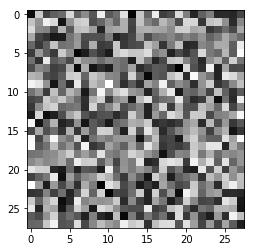

[Epoch - 0] [Batch - 500] - Generator loss = 22.336, Discriminator loss = 0.267
Example fake Generated image


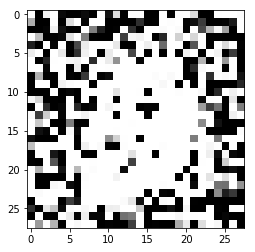

[Epoch - 1] [Batch - 0] - Generator loss = 3.263, Discriminator loss = 0.141
Example fake Generated image


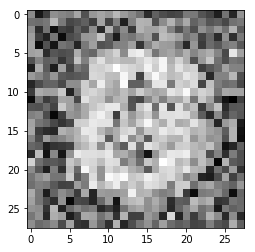

[Epoch - 1] [Batch - 500] - Generator loss = 2.116, Discriminator loss = 0.475
Example fake Generated image


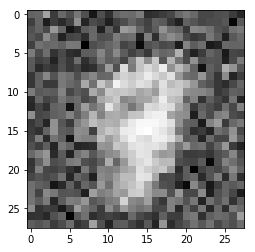

[Epoch - 2] [Batch - 0] - Generator loss = 9.680, Discriminator loss = 0.407
Example fake Generated image


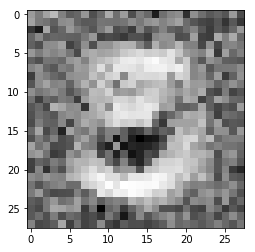

[Epoch - 2] [Batch - 500] - Generator loss = 16.823, Discriminator loss = 0.060
Example fake Generated image


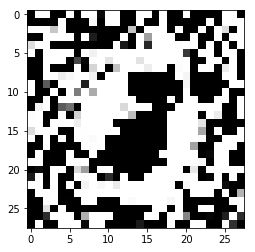

[Epoch - 3] [Batch - 0] - Generator loss = 5.426, Discriminator loss = 0.099
Example fake Generated image


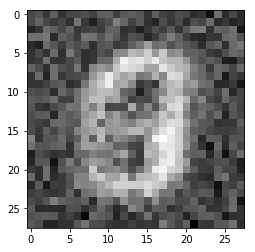

[Epoch - 3] [Batch - 500] - Generator loss = 10.966, Discriminator loss = 0.159
Example fake Generated image


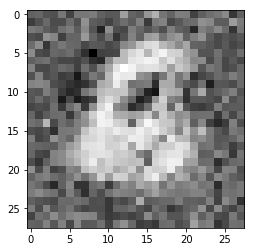

[Epoch - 4] [Batch - 0] - Generator loss = 25.623, Discriminator loss = 0.080
Example fake Generated image


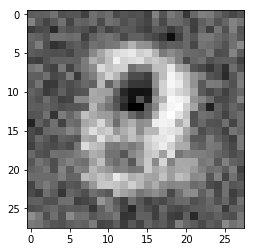

[Epoch - 4] [Batch - 500] - Generator loss = 6.883, Discriminator loss = 0.283
Example fake Generated image


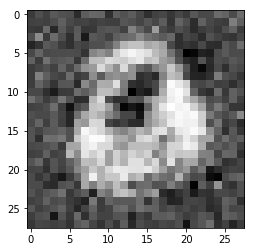

In [144]:
for e in range(epochs):
    for i, (real_imgs, label) in enumerate(train_data):
        real_imgs = real_imgs.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # Adversarial ground truths
        valid = nd.ones(shape=(real_imgs.shape[0], 1))
        fake = nd.zeros(shape=(real_imgs.shape[0], 1))
        
        ############## Train Generator ################
        # Sample random noise for Generator Input
        z = nd.random.normal(loc=0, scale=1, shape=(real_imgs.shape[0], latent_space_dimension))
        
        with autograd.record():
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        trainerG.step(real_imgs.shape[0])
        
        ############# Train Discriminator ###############
        with autograd.record():
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        trainerD.step(real_imgs.shape[0])
        
        # Print loss infomation and a fake image every 500 batches
        if i % 500 == 0:
            print('[Epoch - {}] [Batch - {}] - Generator loss = {:.3f}, Discriminator loss = {:.3f}'
                         .format(e, i, nd.mean(g_loss).asscalar(), nd.mean(d_loss).asscalar()))
            print('Example fake Generated image')
            # Choose a random image from generated image
            rand_index = np.random.randint(0, gen_imgs.shape[0])
            plt.imshow(gen_imgs[rand_index].asnumpy().reshape(28,28), cmap='gray')
            plt.show()